In [1]:
import os
import sys
import shutil
import warnings
import numpy as np
import time
from tqdm import tqdm_notebook
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('..')
warnings.simplefilter('ignore')

from keras.models import load_model
import keras.backend as K
import tensorflow as tf

from segmentation_models.metrics import iou_score

from albumentations import Normalize, Compose

from pascal_voc_data import PascalVocGenerator
from utils import softmax2classes, get_iou, load_graph

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
height = 256
width = 256
num_classes = len(PascalVocGenerator.classes)
batch_size = 1

aug = Compose([
    Normalize(p=1)
])

In [3]:
data_gen = PascalVocGenerator(
    '/data/VOC2012/ImageSets/Segmentation/trainval.txt',
    '/data/VOC2012/JPEGImages/',
    '/data/VOC2012/SegmentationClass/',
    batch_size, (height, width), True, aug, 1
)

In [4]:
graph = load_graph('ENet_256x256.pb')

In [5]:
x = graph.get_tensor_by_name('import/image:0')
y = graph.get_tensor_by_name('import/output/truediv:0')
results = []
# warm CPU or GPU
data_gen.images = np.append(data_gen.images[:1], data_gen.images)
with tf.Session(graph=graph) as sess:
    for _i, (image, true_mask) in tqdm_notebook(enumerate(data_gen), total=len(data_gen)):
        start = time.time()
        pred = sess.run(y, feed_dict={
            x: image
        })
        end = time.time()
        pred_mask = softmax2classes(pred[0], height=height, width=width, num_classes=num_classes)
        iou = get_iou(true_mask[0], pred_mask)[0]
        results.append([iou, end - start])
results = results[1:]
data_gen.images = data_gen.images[1:]

In [6]:
pred_mask_cl = data_gen.categorical_to_mask(pred_mask)
true_mask_cl = data_gen.categorical_to_mask(true_mask[0])
cur_img = (
    (image[0] * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)) * 255
).astype(np.int)

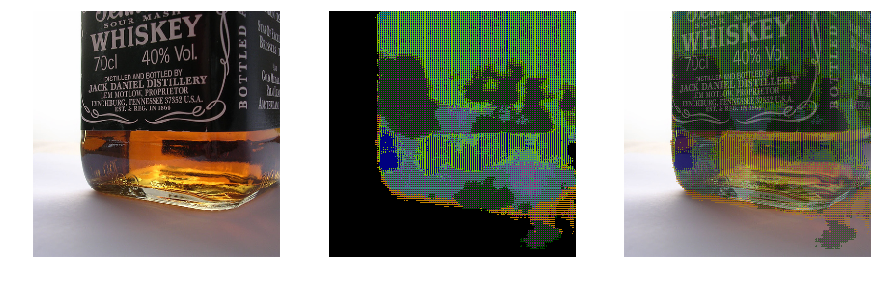

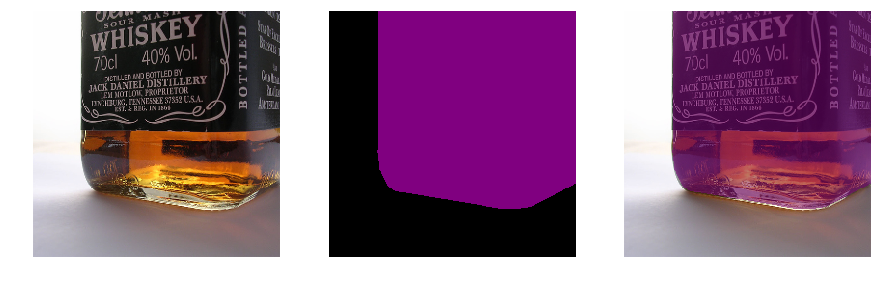

In [7]:
PascalVocGenerator.segmentation_plot(cur_img, pred_mask_cl).show()
PascalVocGenerator.segmentation_plot(cur_img, true_mask_cl).show()

In [8]:
results = np.array(results)
results[:, 0].mean(), results[:, 1].mean()

(0.043300402220851325, 0.01587658692912224)